In [3]:
import os 
import pandas as pd
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169

In [4]:
# It can be used to reconstruct the model identically.
model = tf.keras.models.load_model("resnet_model.h5")


In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [6]:
import tensorflowjs as tfjs

In [7]:
def generate_dataset_from_directory(folder_path, size = 224,batch_size = 32): 

    '''fetch all out test data from directory'''

    image_generator = ImageDataGenerator(
        samplewise_center=True, #Set each sample mean to 0.
        samplewise_std_normalization= True, # Divide each input by its standard deviation]
        #rescale=1./255,
        validation_split = 0.3
    )

    #create training and testing datasets
    train_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="training"
    )

    #create training and testing datasets
    val_data = image_generator.flow_from_directory(directory = 
        folder_path,
        class_mode="categorical",
        color_mode="rgb",
        target_size = (size, size),
        batch_size  = batch_size,
        shuffle=True,
        seed=123,
        subset="validation"
    )

    return train_data, val_data

In [8]:
folder_path = './COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
train_data, val_data = generate_dataset_from_directory(
    folder_path, size = 128,batch_size = 32)

Found 14819 images belonging to 4 classes.
Found 6348 images belonging to 4 classes.


In [9]:
# printing model accuracy for train and test data
test_evaluation = model.evaluate(val_data)
print(f"Test Accuracy using ResNet50: {test_evaluation[1] * 100:.2f}%")

train_evaluation = model.evaluate(train_data)
print(f"Train Accuracy using ResNet50: {train_evaluation[1] * 100:.2f}%")

199/199 [==============================] - 25s 102ms/step - loss: 0.1976 - accuracy: 0.9354
Test Accuracy using ResNet50: 93.54%
464/464 [==============================] - 41s 88ms/step - loss: 0.0347 - accuracy: 0.9900
Train Accuracy using ResNet50: 99.00%


In [19]:
images, labels = next(val_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 128 pixels width and 128 pixels height, one single color channel
The maximum pixel value is 1.9590 and the minimum is -2.6248
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


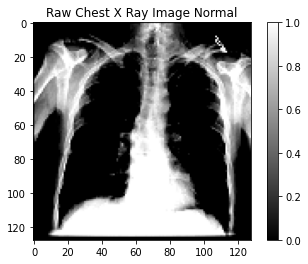

In [20]:
# Investigating single image
raw_image = images[0][:][:]
class_num = list(labels[0]).index(1.0)
class_dict_inv = {v: k for k, v in train_data.class_indices.items()}
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title(f'Raw Chest X Ray Image {class_dict_inv[class_num]}')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

In [21]:
raw_image = raw_image[np.newaxis, :, :, :]
pred_list = list(model.predict(raw_image).flatten())
print(f'Probability for each class: {pred_list}')
print(class_dict_inv)
class_num = pred_list.index(max(pred_list))

print(f'The result of the prediction: {class_dict_inv[class_num]}')

Probability for each class: [0.00037134072, 0.004484362, 0.99506336, 8.08632e-05]
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}
The result of the prediction: Normal


In [22]:
tfjs.converters.save_keras_model(model, 'resnet50_js')


C:\Users\haejo\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
